In [1]:
# probably won't need all of this stuff, but why not import it all?

import SD_raster_loading
import SD_NC_loading
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dalecLoad
import spectralConv

In [14]:
SD_directory = 'C:/Users/daa5/\
OneDrive - University of Stirling/\
PlanetData/\
Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/\
acolite_output/'

file = 'PlanetScope_227a_2022_08_13_11_13_41_L2R.nc' # from 13th Aug, which corresponds to DALEC log 87

f = netCDF4.Dataset(SD_directory+file)
print(f)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    generated_by: ACOLITE
    generated_on: 2022-08-24 10:58:27 GMT Summer Time
    contact: Quinten Vanhellemont
    product_type: NetCDF
    metadata_profile: beam
    metadata_version: 0.5
    auto_grouping: rhot:rhorc:rhos:rhow:Rrs
    Conventions: CF-1.7
    sensor: PlanetScope_SD8
    satellite_sensor: PlanetScope_227a
    isodate: 2022-08-13T11:13:41+00:00
    sza: 43.67708
    vza: 4.941244
    raa: 139.06694
    se_distance: 1.0132199756116838
    mus: 0.7232434613772802
    acolite_file_type: L2R
    oname: PlanetScope_227a_2022_08_13_11_13_41
    ofile: C:/Users/daa5/OneDrive - University of Stirling/PlanetData/Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/acolite_output/PlanetScope_227a_2022_08_13_11_13_41_L2R.nc
    Coastal-Blue_wave: 443.6610607244119
    Coastal-Blue_name: 444
    Coastal-Blue_f0: 19014.80145243501
    Blue_wave: 492.3012651262192
    Blue_name: 492
    Blue_f0: 19688.

In [3]:
print(f.variables.keys()) # get all variable names

dict_keys(['transverse_mercator', 'x', 'y', 'lon', 'lat', 'rhot_444', 'rhos_444', 'rhot_492', 'rhos_492', 'rhot_533', 'rhos_533', 'rhot_566', 'rhos_566', 'rhot_612', 'rhos_612', 'rhot_666', 'rhos_666', 'rhot_707', 'rhos_707', 'rhot_866', 'rhos_866'])


In [4]:
coord = [56.14693897799395, -3.923458784671348] # this is approx the location of the DALEC
coord2 = [56.146746528609306, -3.92285731543299] # this is perhaps a deeper part of the loch

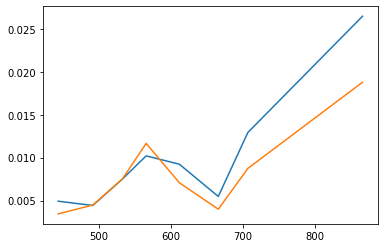

In [5]:
SD_spect1 = SD_NC_loading.get_SD_NC_Spectra(f, coord[0], coord[1])
SD_spect2 = SD_NC_loading.get_SD_NC_Spectra(f, coord2[0], coord2[1])           

plt.plot(SD_spect1['Wavelength'], SD_spect1['Rho_s']/np.pi)
plt.plot(SD_spect2['Wavelength'], SD_spect2['Rho_s']/np.pi)
plt.show()

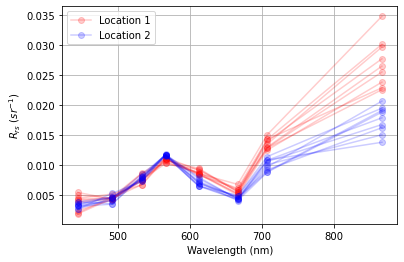

In [6]:
# let's load a 3x3 grid of pixels
SD_spect = SD_NC_loading.get_SD_NC_Spectra_grid(f, coord[0], coord[1], shape=(3, 3)) 
SD_spect2 = SD_NC_loading.get_SD_NC_Spectra_grid(f, coord2[0], coord2[1], shape=(3, 3)) 



fig, ax = plt.subplots()

for col in list(SD_spect.columns.values)[1:]:
    ax.plot(SD_spect['Wavelength'],
             SD_spect[col]/np.pi,
             color='red',
             label='Location 1',
             marker='o',
             alpha=0.2)

for col in list(SD_spect2.columns.values)[1:]:
    ax.plot(SD_spect2['Wavelength'],
            SD_spect2[col]/np.pi,
            color='blue',
            label='Location 2',
            marker='o',
            alpha=0.2)
    
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('$R_{rs}$ $(sr^{-1}$)')


# this code removes duplicate labels in the legend. Naughty
handles, labels = ax.get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax.legend(newHandles, newLabels)

ax.grid()
plt.show()

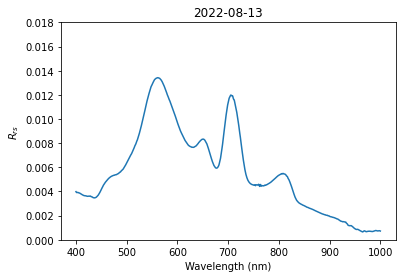

In [7]:
# let's check out the corresponding log file!
filepath = 'data/Jul-Aug/LOG_0087.dtf'
log87 = dalecLoad.load_DALEC_log(filepath)
spect_wavelengths = dalecLoad.load_DALEC_spect_wavelengths(filepath)
mean_spect = dalecLoad.uniform_grid_spectra_mean(log87, spect_wavelengths)

fig, ax = plt.subplots()

ax.plot(mean_spect['Wavelength'], mean_spect['Rrs_mean'])
ax.set_title(str(log87[' UTC Date'].iloc[0])[:10]) # using [:10] as a hacky way to not print the time lol
ax.set_ylim(0, 0.018)
ax.set_ylabel('$R_{rs}$')
ax.set_xlabel('Wavelength (nm)')       

plt.show()

In [8]:
log87.loc[:, 'Lsky', :]['Spectral Magnitude']

Sample #
66242    0.074951
66242    0.075344
66242    0.072599
66242    0.069296
66242    0.071590
           ...   
73863    0.003857
73863    0.006433
73863    0.004211
73863    0.001639
73863    0.003976
Name: Spectral Magnitude, Length: 1524400, dtype: float64

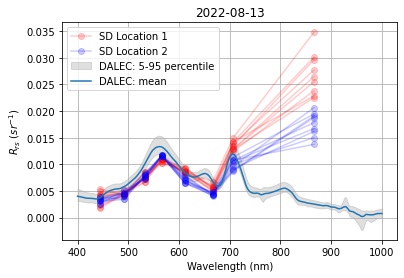

In [9]:
# and plot together: LOOKS ALRIGHT...

fig, ax = plt.subplots()

for col in list(SD_spect.columns.values)[1:]:
    ax.plot(SD_spect['Wavelength'],
             SD_spect[col]/np.pi,
             color='red',
             label='SD Location 1',
             marker='o',
             alpha=0.2)

for col in list(SD_spect2.columns.values)[1:]:
    ax.plot(SD_spect2['Wavelength'],
            SD_spect2[col]/np.pi,
            color='blue',
            label='SD Location 2',
            marker='o',
            alpha=0.2)
    

df_summary = dalecLoad.uniform_grid_spectra_stats(log87, spect_wavelengths, percentiles=[.05, .25, .5, .75, .95])

ax.fill_between(df_summary['wavelength'], df_summary['5%'], y2=df_summary['95%'],
                   color='gray', alpha=0.25, label='DALEC: 5-95 percentile')


ax.plot(df_summary['wavelength'], df_summary['mean'], label='DALEC: mean')
    
#ax.plot(mean_spect['Wavelength'], mean_spect['Rrs_mean'], label='DALEC mean')
ax.set_title(str(log87[' UTC Date'].iloc[0])[:10]) # using [:10] as a hacky way to not print the time lol

    
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('$R_{rs}$ $(sr^{-1}$)')


# this code removes duplicate labels in the legend. Naughty
handles, labels = ax.get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax.legend(newHandles, newLabels)

ax.grid()
plt.show()

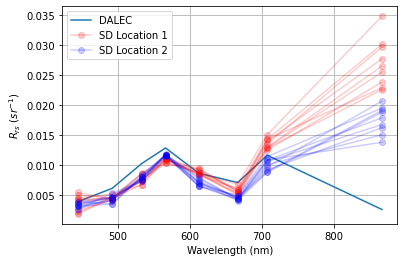

In [10]:
# now let's see what happens when we do the convolution on the DALEC data

RSR_doves = pd.read_csv('non-DALEC-data/RSR-Superdove.csv')
DALEC_SD = spectralConv.SD_band_calc(RSR_doves, mean_spect['Rrs_mean'].values,
                                     RSR_doves['Wavelength (nm)'].values)


fig, ax = plt.subplots()

ax.plot(SD_spect['Wavelength'], DALEC_SD, label='DALEC')

for col in list(SD_spect.columns.values)[1:]:
    ax.plot(SD_spect['Wavelength'],
             SD_spect[col]/np.pi,
             color='red',
             label='SD Location 1',
             marker='o',
             alpha=0.2)

for col in list(SD_spect2.columns.values)[1:]:
    ax.plot(SD_spect2['Wavelength'],
            SD_spect2[col]/np.pi,
            color='blue',
            label='SD Location 2',
            marker='o',
            alpha=0.2)
    

    
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('$R_{rs}$ $(sr^{-1}$)')
    
# this code removes duplicate labels in the legend. Naughty
handles, labels = ax.get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax.legend(newHandles, newLabels)

ax.grid()
plt.show()

In [20]:
# now gonna try to look at all SD files:
import os
SD_files = []
for file in os.listdir(SD_directory):
    if file.endswith("L2R.nc"):
        SD_files.append(os.path.join(SD_directory, file))
SD_files

['C:/Users/daa5/OneDrive - University of Stirling/PlanetData/Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/acolite_output/PlanetScope_227a_2022_08_13_11_13_41_L2R.nc',
 'C:/Users/daa5/OneDrive - University of Stirling/PlanetData/Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/acolite_output/PlanetScope_2427_2022_08_11_10_28_21_L2R.nc',
 'C:/Users/daa5/OneDrive - University of Stirling/PlanetData/Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/acolite_output/PlanetScope_2427_2022_08_11_10_28_23_L2R.nc',
 'C:/Users/daa5/OneDrive - University of Stirling/PlanetData/Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/acolite_output/PlanetScope_2432_2022_08_10_10_27_06_L2R.nc',
 'C:/Users/daa5/OneDrive - University of Stirling/PlanetData/Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/acolite_output/PlanetScope_2436_2022_08_20_10_26_47_L2R.nc',
 'C:/Users/daa5/OneDrive - University of Stirling/PlanetData/Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/acolite_output/PlanetScope_2482_2022_08_17_11_0

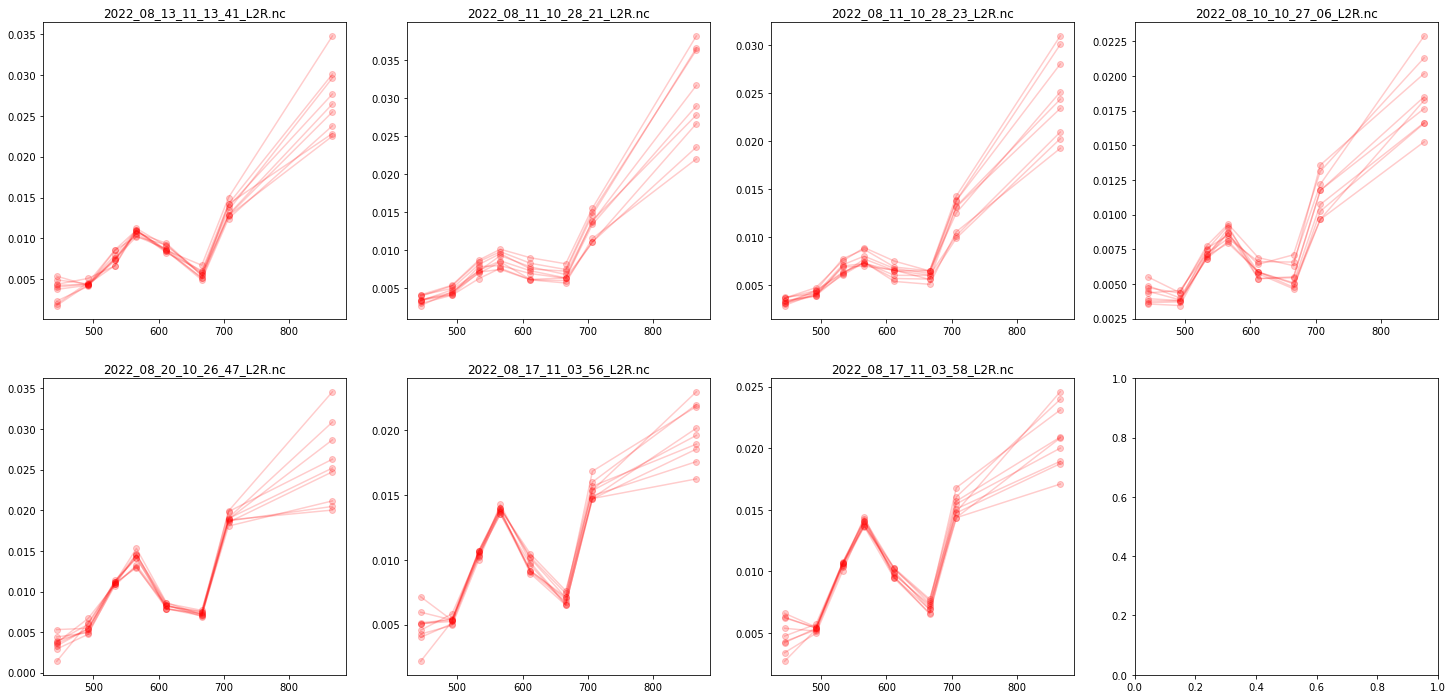

In [21]:
fig, ax = plt.subplots(2, 4, figsize=(25, 12))

ax = ax.flatten()

for i in range(len(SD_files)):
    f = netCDF4.Dataset(SD_files[i])
    SD_spect = SD_NC_loading.get_SD_NC_Spectra_grid(f, coord[0], coord[1], shape=(3, 3)) 
    
    for col in list(SD_spect.columns.values)[1:]:
        ax[i].plot(SD_spect['Wavelength'],
                 SD_spect[col]/np.pi,
                 color='red',
                 label='Location 1',
                 marker='o',
                 alpha=0.2)
    
    ax[i].set_title(SD_files[i][-26:]) # note that currently files aren't in the right order... this is annoying!
plt.show()

In [26]:
# so it's pretty easy to get the datetime from the loaded ncdf file:
# just need to think of some nice way to load in the data so that it has the date attached to it
pd.to_datetime(f.isodate)

Timestamp('2022-08-17 11:03:58+0000', tz='UTC')